Here we use crossing statistics. For simplicity we choose only two images.

In [187]:
import numpy as np
import lmfit
import matplotlib.pyplot as plt
import pystan
import emcee
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib

In [188]:
%matplotlib inline
np.random.seed(15)
tk=10.0
def intrinsic_func(t,mu,dt):
    t1=t+dt;
    t1[t1<0]=0
    return mu*(t1)**2*np.exp(-(t1)/tk)

t_max=100.0; t_min=0.0; t_range=t_max-t_min; Ndata=200;
t=t_min+np.random.rand(Ndata)*t_range;t=np.sort(t);
#a slight shift is given because fitting may have problem with a very small \sigma 
print(np.amin(t), np.amax(t))

0.16447577600704477 99.8543402727172


**The first image arrives (blue) at $t=0$, and the the 2nd image (green) arrives a bit earlier, so we see only a part of it.** 

First consider smaller errorbars

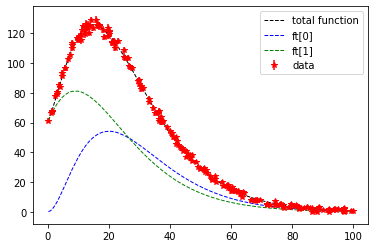

In [189]:
#mu and dt for the images
mu_l=[1.0,1.5]
dt_l=[0.0,11.0]
#for simplicity just consider the 1st NI images for now
NI=2; #just take two signal/image 
ft=np.zeros((NI,Ndata))

for i in np.arange(NI): 
    ft[i]=intrinsic_func(t,mu_l[i],dt_l[i])
    
ft_total=np.sum(ft,axis=0)
sigft=0.01*ft_total+1.0  #10*(0.2+np.random.rand(len(t)))
#sigft=10*(0.2+np.random.rand(len(t)))
np.random.seed(37)

y=np.random.normal(ft_total, sigft)#this is my data

plt.errorbar(t,y,yerr=sigft,fmt='r*',label=r"data") #data
plt.plot(t,ft_total,c='k',lw=1.0,ls="--", label=r"total function")
clr=["b","g","c","orange"]
for i in range(NI):
    plt.plot(t,ft[i],c=clr[i],lw=1.0,ls="--", label=r"ft[%d]"%(i))

plt.legend(loc=0)
plt.show()

In [190]:
#template 1: log-normal, crossing statistics upto 4th order
tmax=np.amax(t)

def mod(x,mean,sig,s,c0,c1,c2,c3,c4):
    x=x-s*x;#s=stretch
    x[x<1e-15]=1e-15# this makes the intrinsic flux->0 for t<0
    #log-normal
    fx=(1.0/(sig*np.sqrt(2.0*np.pi)*x))*np.exp(-0.5*(np.log(x)-mean)**2/(sig*sig))
    #crossing statistics
    xs=x/tmax
    fx_mod=fx*(c0+c1*xs+c2*(2.0*xs*xs -1.0)+c3*(4.0*xs*xs*xs-3.0*xs) + c4*(8.0*xs*xs*xs*xs-8.0*xs*xs + 1.0));
    return fx_mod

#with lmfit emcee (MCMC)
p = lmfit.Parameters()
p.add_many(('mean', 1.0, True, 0.1,5.0), ('sig', 0.5, True, 0.0,2.0),('s', 0.01,True, 0.0,0.99));#, ;
p.add_many(('mu1', 1.5, True, 0.5,1.8),('dt1',5.0, True,0.2,None));
#p.add('dt2', value=0.50, min=0, max=10.0)
p.add_many(('c0', 600.0, True,10.0,1500.0),('c1', 0.1, True, None,None),('c2', 0.1, True, None,None),
           ('c3', 0.1, True, None,None) ,('c4', 0.1, True, None,None))

def residual(p):
    v = p.valuesdict()
    return (mod(t,v['mean'],v['sig'],v['s'],v['c0'],v['c1'],v['c2'],v['c3'],v['c4'])+v['mu1']*mod(t+v['dt1'],v['mean'],v['sig'],v['s'],v['c0'],v['c1'],v['c2'],v['c3'],v['c4'])- y)/sigft


p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=400, steps=6000, thin=3, nwalkers=150,
                     params=p, is_weighted=False)
lmfit.report_fit(res.params)

100%|██████████| 6000/6000 [02:30<00:00, 39.93it/s]


[[Variables]]
    mean:       3.16833543 +/- 0.12824213 (4.05%) (init = 1)
    sig:        0.71518444 +/- 0.01990692 (2.78%) (init = 0.5)
    s:          0.19745381 +/- 0.09450090 (47.86%) (init = 0.01)
    mu1:        1.76241839 +/- 0.04462261 (2.53%) (init = 1.5)
    dt1:        11.1583848 +/- 0.26804435 (2.40%) (init = 5)
    c0:         766.162883 +/- 513.683312 (67.05%) (init = 600)
    c1:        -51.1718376 +/- 903.361682 (1765.35%) (init = 0.1)
    c2:         1293.52839 +/- 1403.57800 (108.51%) (init = 0.1)
    c3:        -2002.52967 +/- 1476.31046 (73.72%) (init = 0.1)
    c4:         1547.23321 +/- 734.575622 (47.48%) (init = 0.1)
    __lnsigma:  0.06496497 +/- 0.05782456 (89.01%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(c2, c4)         =  0.921
    C(c2, c3)         = -0.912
    C(sig, dt1)       = -0.854
    C(c3, c4)         = -0.827
    C(c0, c1)         = -0.796
    C(mean, c4)       = -0.754
    C(mean, c2)       = -0.747
    C(si

In this notebook we always plot just the best-fit. But in most cases, the best-fit point is found near the median.


Maximum likelihood Estimation
-----------------------------
Maximum liklihood: mu= 1.7999164346365482 dt= 11.026668896647584


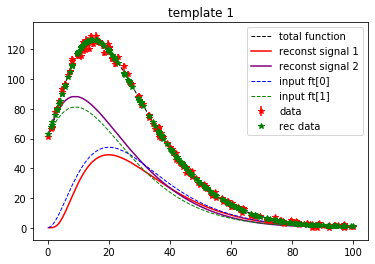

Chi^2 actual= 201.93980717339548 Chi^2 pystan rec= 214.88073641012852


In [191]:
def plot_func1(res):
    highest_prob = np.argmax(res.lnprob)
    hp_loc = np.unravel_index(highest_prob, res.lnprob.shape)
    mle_soln = res.chain[hp_loc]
    #print(mle_soln.shape)
    #sys.exit()
    #for i, par in enumerate(p):
    #p[par].value = mle_soln[i]
    #print(mle_soln[i])
    print("\nMaximum likelihood Estimation")
    print('-----------------------------')
    [mm,sigm,sm,mum,dtm,c0m,c1m,c2m,c3m,c4m,lnm]=mle_soln;#c4m=0; #sm=0; #mum=1.5;
    print("Maximum liklihood: mu=",mum, "dt=",dtm)

    #print(p)
    Ps1=mod(t,mm,sigm,sm,c0m,c1m,c2m,c3m,c4m)
    Ps2=mum*mod(t+dtm,mm,sigm,sm,c0m,c1m,c2m,c3m,c4m)
    Ps=Ps1+Ps2
    plt.title(r'template 1')
    plt.errorbar(t,y,yerr=sigft,fmt='r*',label=r"data") #data
    plt.plot(t,ft_total,c='k',lw=1.0,ls="--", label=r"total function")
    plt.plot(t,Ps1,c="r", label=r"reconst signal 1")  
    plt.plot(t,Ps2,c="purple", label=r"reconst signal 2")
    clr=["b","g","c","orange"]
    for i in range(NI):
        plt.plot(t,ft[i],c=clr[i],lw=1.0,ls="--", label=r"input ft[%d]"%(i))

     
    plt.errorbar(t,Ps,fmt='g*',label=r"rec data") #data    
    plt.legend(loc=0)
    plt.show()
    chisq=np.sum((Ps-y)**2/sigft**2)
    chisq_o=np.sum((ft_total-y)**2/sigft**2)
    print("Chi^2 actual=",chisq_o,"Chi^2 pystan rec=",chisq)
    
plot_func1(res)

Template 1 (log-normal) is  not bad. But we require a very tight prior on mu here. The prior on dt can be more relaxed.

Trying another function: $t^n \times \exp[-t/t_k]$ along with the crossing statistics. Note that the simulated data were generated from a memeber function of the set, namely: $t^2 \times \exp[-t/10]$. So we can expect to have better fit.

In [192]:
#template 2: t^n exp(-t/tk); no stretch, crossing statistics upto 2nd order

tmax=np.amax(t)

def mod2(x,n,xk,s,c0,c1,c2,c3,c4):
    x=x-s*x;
    x[x<1e-15]=1e-15
    fx=(x**n)*np.exp(-x/xk)
    xs=x/tmax
    fx_mod=fx*(c0+c1*xs+c2*(2.0*xs*xs-1)+c3*(4.0*xs*xs*xs-3.0*xs) + c4*(8.0*xs*xs*xs*xs-8.0*xs*xs+1.0));
    return fx_mod

#with lmfit emcee (MCMC)
p = lmfit.Parameters()
p.add_many(('n', 2.0, True, 1.0,4.0), ('tk', 10.0, True, 5.0,20.0),('s', 0,False, 0.0,0.5));#, ;
p.add_many(('mu1', 1.5, True, 0.5,2.0),('dt1',10.0, True,0.0,20.0));
#p.add('dt2', value=0.50, min=0, max=10.0)
p.add_many(('c0', 1.0, True,None,None),('c1', 0.1, True, None,None),('c2', 0.1, True, None,None),
           ('c3', 0, False, None,None) ,('c4', 0.0,False, None,None))

def residual(p):
    v = p.valuesdict()
    return (mod2(t,v['n'],v['tk'],v['s'],v['c0'],v['c1'],v['c2'],v['c3'],v['c4'])
            +v['mu1']*mod2(t+v['dt1'],v['n'],v['tk'],v['s'],v['c0'],v['c1'],v['c2'],v['c3'],v['c4'])- y)/sigft


p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

res2 = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=400, steps=6000, thin=3, nwalkers=150,
                     params=p, is_weighted=False,seed=20145)
lmfit.report_fit(res2.params)

100%|██████████| 6000/6000 [02:51<00:00, 35.04it/s]


[[Variables]]
    n:          1.92109022 +/- 0.07729660 (4.02%) (init = 2)
    tk:         10.2200783 +/- 0.60635042 (5.93%) (init = 10)
    s:          0 (fixed)
    mu1:        1.67605723 +/- 0.21495968 (12.83%) (init = 1.5)
    dt1:        10.6165109 +/- 0.50773609 (4.78%) (init = 10)
    c0:         0.84297178 +/- 0.22151858 (26.28%) (init = 1)
    c1:         0.39528994 +/- 0.60990605 (154.29%) (init = 0.1)
    c2:        -0.18432082 +/- 0.20652003 (112.04%) (init = 0.1)
    c3:         0 (fixed)
    c4:         0 (fixed)
    __lnsigma:  0.00980763 +/- 0.05173843 (527.53%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu1, dt1) = -0.825
    C(n, c2)    =  0.770
    C(mu1, c0)  = -0.736
    C(n, tk)    = -0.659
    C(c0, c1)   = -0.647
    C(c0, c2)   =  0.587
    C(tk, c1)   = -0.579
    C(dt1, c0)  =  0.572
    C(c1, c2)   = -0.508
    C(mu1, c1)  =  0.399
    C(dt1, c1)  = -0.358
    C(tk, mu1)  = -0.349
    C(tk, c2)   = -0.341
    C(dt1, c2)  


Maximum likelihood Estimation
-----------------------------
Maximum liklihood: mu= 1.5738466649338565 dt= 10.700391253547108


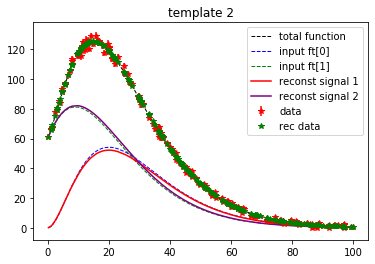

Chi^2 actual= 201.93980717339548 Chi^2 pystan rec= 197.49864430230804


In [193]:
def plot_func2(res):
    highest_prob = np.argmax(res.lnprob)
    hp_loc = np.unravel_index(highest_prob, res.lnprob.shape)
    mle_soln = res.chain[hp_loc]
    #print(mle_soln.shape)
    #sys.exit()
    #for i, par in enumerate(p):
    #p[par].value = mle_soln[i]
    #print(mle_soln[i])
    print("\nMaximum likelihood Estimation")
    print('-----------------------------')
    c4m=0; sm=0; c3m=0;#mum=1.5;
    [nm,tkm,mum,dtm,c0m,c1m,c2m,lnm]=mle_soln;
    #print(nm,tkm,mum,dtm,c0m,c1m,c2m,c3m,c4m,lnm)
    print("Maximum liklihood: mu=",mum, "dt=",dtm)

    #print(p)
    Ps1=mod2(t,nm,tkm,sm,c0m,c1m,c2m,c3m,c4m)
    Ps2=mum*mod2(t+dtm,nm,tkm,sm,c0m,c1m,c2m,c3m,c4m)
    Ps=Ps1+Ps2
    plt.title(r'template 2')
    plt.errorbar(t,y,yerr=sigft,fmt='r*',label=r"data") #data
    plt.plot(t,ft_total,c='k',lw=1.0,ls="--", label=r"total function")
    clr=["b","g","c","orange"]
    for i in range(NI):
        plt.plot(t,ft[i],c=clr[i],lw=1.0,ls="--", label=r"input ft[%d]"%(i))

    plt.plot(t,Ps1,c="r", label=r"reconst signal 1")  
    plt.plot(t,Ps2,c="purple",label=r"reconst signal 2") 
    plt.errorbar(t,Ps,fmt='g*',label=r"rec data") #data    
    plt.legend(loc=0)
    plt.show()
    chisq=np.sum((Ps-y)**2/sigft**2)
    chisq_o=np.sum((ft_total-y)**2/sigft**2)
    print("Chi^2 actual=",chisq_o,"Chi^2 pystan rec=",chisq)
    
    
plot_func2(res2)

Template 2 fits much better, when the errorbars are pretty small. The prior on mu is not required to be very strict here. 

**Now we generate the images with bigger errorbars, somewhat consistent with the gLSNe simulated data.**

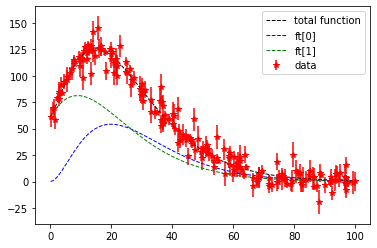

In [194]:
#mu and dt for the images
mu_l=[1.0,1.5]
dt_l=[0.0,11.0]
#for simplicity just consider the 1st NI images for now
NI=2; #just take two signal/image 
ft=np.zeros((NI,Ndata))

for i in np.arange(NI): 
    ft[i]=intrinsic_func(t,mu_l[i],dt_l[i])
    
ft_total=np.sum(ft,axis=0)
#bigger errorbars
sigft=10*(0.2+np.random.rand(len(t)))
np.random.seed(37)

y=np.random.normal(ft_total, sigft)#this is my data

plt.errorbar(t,y,yerr=sigft,fmt='r*',label=r"data") #data
plt.plot(t,ft_total,c='k',lw=1.0,ls="--", label=r"total function")
clr=["b","g","c","orange"]
for i in range(NI):
    plt.plot(t,ft[i],c=clr[i],lw=1.0,ls="--", label=r"ft[%d]"%(i))

plt.legend(loc=0)
plt.show()

In [195]:
#template 1: log-normal, crossing statistics upto 4th order

tmax=np.amax(t)

def mod(x,mean,sig,s,c0,c1,c2,c3,c4):
    x=x-s*x;#s=stretch
    x[x<1e-15]=1e-15# this makes the intrinsic flux->0 for t<0
    #log-normal
    fx=(1.0/(sig*np.sqrt(2.0*np.pi)*x))*np.exp(-0.5*(np.log(x)-mean)**2/(sig*sig))
    #crossing statistics
    xs=x/tmax
    fx_mod=fx*(c0+c1*xs+c2*(2.0*xs*xs -1.0)+c3*(4.0*xs*xs*xs-3.0*xs) + c4*(8.0*xs*xs*xs*xs-8.0*xs*xs + 1.0));
    return fx_mod

#with lmfit emcee (MCMC)
p = lmfit.Parameters()
p.add_many(('mean', 1.0, True, 0.1,5.0), ('sig', 0.5, True, 0.0,2.0),('s', 0.01,True, 0.0,0.99));#, ;
p.add_many(('mu1', 1.5, True, 0.5,1.8),('dt1',5.0, True,0.2,None));
#p.add('dt2', value=0.50, min=0, max=10.0)
p.add_many(('c0', 600.0, True,10.0,1500.0),('c1', 0.1, True, None,None),('c2', 0.1, True, None,None),
           ('c3', 0.1, True, None,None) ,('c4', 0.1, True, None,None))

def residual(p):
    v = p.valuesdict()
    return (mod(t,v['mean'],v['sig'],v['s'],v['c0'],v['c1'],v['c2'],v['c3'],v['c4'])+v['mu1']*mod(t+v['dt1'],v['mean'],v['sig'],v['s'],v['c0'],v['c1'],v['c2'],v['c3'],v['c4'])- y)/sigft


p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

res3 = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=400, steps=6000, thin=3, nwalkers=150,
                     params=p, is_weighted=False)
lmfit.report_fit(res3.params)

100%|██████████| 6000/6000 [02:18<00:00, 43.41it/s]


[[Variables]]
    mean:       3.08714250 +/- 0.20388281 (6.60%) (init = 1)
    sig:        0.78362710 +/- 0.07273228 (9.28%) (init = 0.5)
    s:          0.34986733 +/- 0.12800642 (36.59%) (init = 0.01)
    mu1:        1.54122570 +/- 0.25222768 (16.37%) (init = 1.5)
    dt1:        11.9876482 +/- 1.05009742 (8.76%) (init = 5)
    c0:         807.067266 +/- 534.618857 (66.24%) (init = 600)
    c1:         1759.25123 +/- 3256.79381 (185.12%) (init = 0.1)
    c2:         1424.11803 +/- 2959.62664 (207.82%) (init = 0.1)
    c3:        -393.250884 +/- 2794.15733 (710.53%) (init = 0.1)
    c4:         2170.04614 +/- 2306.29405 (106.28%) (init = 0.1)
    __lnsigma:  0.01731953 +/- 0.05862246 (338.48%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(c2, c4)          =  0.955
    C(c2, c3)          = -0.719
    C(mean, c2)        = -0.674
    C(mu1, dt1)        = -0.643
    C(s, c3)           =  0.593
    C(mean, c4)        = -0.570
    C(c3, c4)          = -0.56


Maximum likelihood Estimation
-----------------------------
Maximum liklihood: mu= 1.7490207665895026 dt= 11.165570301427712


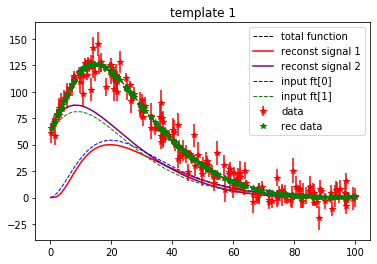

Chi^2 actual= 201.93980717339545 Chi^2 pystan rec= 196.10485133698234


In [196]:
plot_func1(res3)

With larger errorbars template 1 works really well. Although we still need very sharp prior on mu.

In [197]:
#template 2: t^n exp(-t/tk); no stretch, crossing statistics upto 2nd order

tmax=np.amax(t)

def mod2(x,n,xk,s,c0,c1,c2,c3,c4):
    x=x-s*x;
    x[x<1e-15]=1e-15
    fx=(x**n)*np.exp(-x/xk)
    xs=x/tmax
    fx_mod=fx*(c0+c1*xs+c2*(2.0*xs*xs-1)+c3*(4.0*xs*xs*xs-3.0*xs) + c4*(8.0*xs*xs*xs*xs-8.0*xs*xs+1.0));
    return fx_mod

#with lmfit emcee (MCMC)
p = lmfit.Parameters()
p.add_many(('n', 2.0, True, 1.0,4.0), ('tk', 10.0, True, 5.0,20.0),('s', 0,False, 0.0,0.5));#, ;
p.add_many(('mu1', 1.5, True, 0.5,2.0),('dt1',10.0, True,0.0,20.0));
#p.add('dt2', value=0.50, min=0, max=10.0)
p.add_many(('c0', 1.0, True,None,None),('c1', 0.1, True, None,None),('c2', 0.1, True, None,None),
           ('c3', 0, False, None,None) ,('c4', 0.0,False, None,None))

def residual(p):
    v = p.valuesdict()
    return (mod2(t,v['n'],v['tk'],v['s'],v['c0'],v['c1'],v['c2'],v['c3'],v['c4'])
            +v['mu1']*mod2(t+v['dt1'],v['n'],v['tk'],v['s'],v['c0'],v['c1'],v['c2'],v['c3'],v['c4'])- y)/sigft


p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

res4 = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=400, steps=6000, thin=3, nwalkers=150,
                     params=p, is_weighted=False,seed=20145)
lmfit.report_fit(res4.params)

100%|██████████| 6000/6000 [02:50<00:00, 35.11it/s]


[[Variables]]
    n:          1.91796878 +/- 0.17498977 (9.12%) (init = 2)
    tk:         10.0118241 +/- 1.22794252 (12.26%) (init = 10)
    s:          0 (fixed)
    mu1:        1.57418439 +/- 0.31008769 (19.70%) (init = 1.5)
    dt1:        11.2050170 +/- 1.27640311 (11.39%) (init = 10)
    c0:         0.97769224 +/- 0.70871033 (72.49%) (init = 1)
    c1:         0.45527469 +/- 1.24623843 (273.73%) (init = 0.1)
    c2:        -0.14294264 +/- 0.73953898 (517.37%) (init = 0.1)
    c3:         0 (fixed)
    c4:         0 (fixed)
    __lnsigma:  0.00760854 +/- 0.05165870 (678.96%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(c0, c2)   =  0.899
    C(n, tk)    = -0.784
    C(mu1, dt1) = -0.774
    C(n, c2)    =  0.700
    C(c0, c1)   = -0.622
    C(tk, c2)   = -0.586
    C(c1, c2)   = -0.544
    C(mu1, c0)  = -0.442
    C(mu1, c1)  =  0.400
    C(n, c0)    =  0.373
    C(n, dt1)   =  0.341
    C(n, c1)    = -0.334
    C(tk, c0)   = -0.278
    C(dt1, c0)


Maximum likelihood Estimation
-----------------------------
Maximum liklihood: mu= 1.4067450490222144 dt= 10.980176320358476


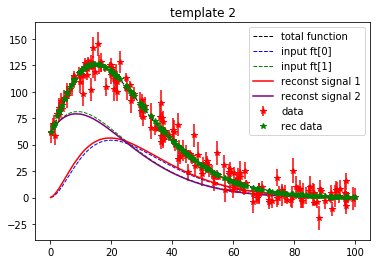

Chi^2 actual= 201.93980717339545 Chi^2 pystan rec= 196.59297482562636


In [198]:
plot_func2(res4)

Template 2 again does well. 

**Now we consider another system. Here the first image arrives at $t=0$, and the second image arrives later (negative time delay according to our convention). So the 2nd image has a zero plateau (see the green curve below).**

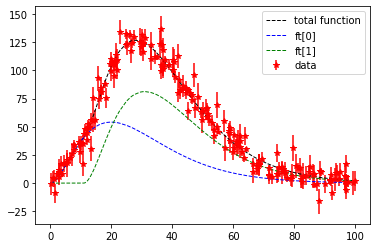

In [199]:
#template 1: log-normal, crossing statistics upto 4th order
#mu and dt for the images

def intrinsic_func(t,mu,dt):
    t1=t+dt;
    t1[t1<0]=0
    return mu*(t1)**2*np.exp(-(t1)/tk)

mu_l=[1.0,1.5]
dt_l=[0.0,-11.0]
#for simplicity just consider the 1st NI images for now
NI=2; #just take two signal/image 
ft=np.zeros((NI,Ndata))

for i in np.arange(NI): 
    ft[i]=intrinsic_func(t,mu_l[i],dt_l[i])
    
ft_total=np.sum(ft,axis=0)
#bigger errorbars
sigft=10*(0.2+np.random.rand(len(t)))
np.random.seed(37)

y=np.random.normal(ft_total, sigft)#this is my data

plt.errorbar(t,y,yerr=sigft,fmt='r*',label=r"data") #data
plt.plot(t,ft_total,c='k',lw=1.0,ls="--", label=r"total function")
clr=["b","g","c","orange"]
for i in range(NI):
    plt.plot(t,ft[i],c=clr[i],lw=1.0,ls="--", label=r"ft[%d]"%(i))

plt.legend(loc=0)
plt.show()

In the code given below, we force $dt>0$ which means the intrinsic light curve (the function mod) models the most delayed (right most, the green curve above) image, the 2nd image is the one which arrives earlier (blue in above figure). So we expect mu=0.667, dt=11.0

100%|██████████| 6000/6000 [02:17<00:00, 43.59it/s]


[[Variables]]
    mean:       3.21818123 +/- 0.15773137 (4.90%) (init = 1)
    sig:        0.39627938 +/- 0.06336251 (15.99%) (init = 0.5)
    s:          0.30064939 +/- 0.12292995 (40.89%) (init = 0.01)
    mu1:        0.57669037 +/- 0.33198787 (57.57%) (init = 1.5)
    dt1:        10.9054923 +/- 0.86810228 (7.96%) (init = 10)
    c0:         868.539952 +/- 526.564719 (60.63%) (init = 600)
    c1:         259.459999 +/- 18803.2483 (7247.07%) (init = 0.1)
    c2:        -4387.80514 +/- 8394.33186 (191.31%) (init = 0.1)
    c3:         1291.54822 +/- 10165.1213 (787.05%) (init = 0.1)
    c4:        -2316.62600 +/- 6718.16990 (290.00%) (init = 0.1)
    __lnsigma:  0.04849863 +/- 0.06536970 (134.79%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(c2, c4)          =  0.992
    C(c1, c3)          =  0.881
    C(sig, dt1)        = -0.768
    C(mean, s)         = -0.743
    C(sig, c3)         = -0.731
    C(sig, c2)         =  0.563
    C(dt1, c3)         =  0

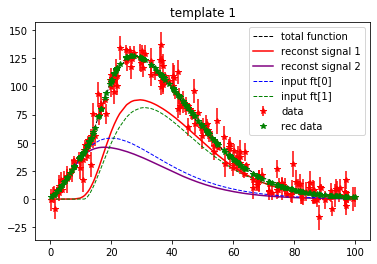

Chi^2 actual= 201.93980717339548 Chi^2 pystan rec= 192.9479434335801


In [200]:
#template 1: log-normal, crossing statistics upto 4th order

tmax=np.amax(t)

def mod(x,mean,sig,s,c0,c1,c2,c3,c4):
    x=x-s*x;#s=stretch
    x[x<1e-15]=1e-15# this makes the intrinsic flux->0 for t<0
    #log-normal
    fx=(1.0/(sig*np.sqrt(2.0*np.pi)*x))*np.exp(-0.5*(np.log(x)-mean)**2/(sig*sig))
    #crossing statistics
    xs=x/tmax
    fx_mod=fx*(c0+c1*xs+c2*(2.0*xs*xs -1.0)+c3*(4.0*xs*xs*xs-3.0*xs) + c4*(8.0*xs*xs*xs*xs-8.0*xs*xs + 1.0));
    return fx_mod

#with lmfit emcee (MCMC)
p = lmfit.Parameters()
p.add_many(('mean', 1.0, True, 0.1,5.0), ('sig', 0.5, True, 0.0,2.0),('s', 0.01,True, 0.0,0.99));#, ;
p.add_many(('mu1', 1.5, True, 0.5,2.0),('dt1',10.0, True,0.0,20.0));
#p.add('dt2', value=0.50, min=0, max=10.0)
p.add_many(('c0', 600.0, True,10.0,1500.0),('c1', 0.1, True, None,None),('c2', 0.1, True, None,None),
           ('c3', 0.1, True, None,None) ,('c4', 0.1, True, None,None))

def residual(p):
    v = p.valuesdict()
    return (mod(t,v['mean'],v['sig'],v['s'],v['c0'],v['c1'],v['c2'],v['c3'],v['c4'])+v['mu1']*mod(t+v['dt1'],v['mean'],v['sig'],v['s'],v['c0'],v['c1'],v['c2'],v['c3'],v['c4'])- y)/sigft


p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

res5 = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=400, steps=6000, thin=3, nwalkers=150,
                     params=p, is_weighted=False)
lmfit.report_fit(res5.params)
plot_func1(res5)

The fitting for mu and dt is quite good. The other parameters are not well constrained though.

100%|██████████| 6000/6000 [02:43<00:00, 36.74it/s]


[[Variables]]
    n:          2.65366648 +/- 0.17716237 (6.68%) (init = 2)
    tk:         8.08197125 +/- 0.66738882 (8.26%) (init = 10)
    s:          0 (fixed)
    mu1:        0.92501351 +/- 0.28629982 (30.95%) (init = 1.5)
    dt1:        12.1223361 +/- 3.43073477 (28.30%) (init = 10)
    c0:        -0.52052264 +/- 0.51494196 (98.93%) (init = 1)
    c1:         1.88864655 +/- 1.44240754 (76.37%) (init = 0.1)
    c2:        -0.36890824 +/- 0.40426520 (109.58%) (init = 0.1)
    c3:         0 (fixed)
    c4:         0 (fixed)
    __lnsigma:  0.09605266 +/- 0.06266776 (65.24%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(c0, c2)         =  0.901
    C(c0, c1)         = -0.768
    C(tk, __lnsigma)  =  0.749
    C(tk, dt1)        = -0.730
    C(dt1, c1)        =  0.711
    C(n, tk)          = -0.648
    C(dt1, __lnsigma) = -0.641
    C(n, c1)          = -0.532
    C(mu1, c1)        =  0.522
    C(mu1, dt1)       =  0.462
    C(c1, c2)         = -0.440
 

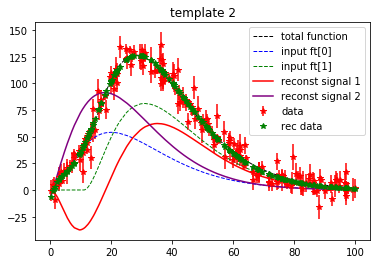

Chi^2 actual= 201.93980717339548 Chi^2 pystan rec= 224.60021819906171


In [201]:
#template 2: t^n exp(-t/tk); no stretch, crossing statistics upto 2nd order

tmax=np.amax(t)

def mod2(x,n,xk,s,c0,c1,c2,c3,c4):
    x=x-s*x;
    x[x<1e-15]=1e-15
    fx=(x**n)*np.exp(-x/xk)
    xs=x/tmax
    fx_mod=fx*(c0+c1*xs+c2*(2.0*xs*xs-1)+c3*(4.0*xs*xs*xs-3.0*xs) + c4*(8.0*xs*xs*xs*xs-8.0*xs*xs+1.0));
    return fx_mod

#with lmfit emcee (MCMC)
p = lmfit.Parameters()
p.add_many(('n', 2.0, True, 1.0,4.0), ('tk', 10.0, True, 5.0,20.0),('s', 0,False, 0.0,0.5));#, ;
p.add_many(('mu1', 1.5, True, 0.5,2.0),('dt1',10.0, True,0.0,20.0));
#p.add('dt2', value=0.50, min=0, max=10.0)
p.add_many(('c0', 1.0, True,None,None),('c1', 0.1, True, None,None),('c2', 0.1, True, None,None),
           ('c3', 0, False, None,None) ,('c4', 0.0,False, None,None))

def residual(p):
    v = p.valuesdict()
    return (mod2(t,v['n'],v['tk'],v['s'],v['c0'],v['c1'],v['c2'],v['c3'],v['c4'])
            +v['mu1']*mod2(t+v['dt1'],v['n'],v['tk'],v['s'],v['c0'],v['c1'],v['c2'],v['c3'],v['c4'])- y)/sigft


p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

res6 = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=400, steps=6000, thin=3, nwalkers=150,
                     params=p, is_weighted=False,seed=20145)
lmfit.report_fit(res6.params)
plot_func2(res6)

The total light curve is fitted well, but the individual images are bad. This is probably because this template cannot model the zero flat branch of the latest image well.  

Now we restrict the time delay $dt<0$. So in the codes below the mod functions actually model the earliest image. SO we expect mu=1.5 (as before) and dt=-11.0 

100%|██████████| 6000/6000 [02:35<00:00, 38.66it/s]


[[Variables]]
    mean:       3.32714857 +/- 0.22769206 (6.84%) (init = 1)
    sig:        0.92522798 +/- 0.05106274 (5.52%) (init = 0.5)
    s:          0.19056722 +/- 0.11769298 (61.76%) (init = 0.01)
    mu1:        1.59911172 +/- 0.11125938 (6.96%) (init = 1.5)
    dt1:       -11.3597327 +/- 0.35467928 (3.12%) (init = -10)
    c0:         699.978439 +/- 515.643629 (73.67%) (init = 600)
    c1:         2002.57563 +/- 3448.92897 (172.22%) (init = 0.1)
    c2:         4009.27308 +/- 3238.05992 (80.76%) (init = 0.1)
    c3:        -3116.67564 +/- 2398.23397 (76.95%) (init = 0.1)
    c4:         4186.63556 +/- 2071.89811 (49.49%) (init = 0.1)
    __lnsigma:  0.01332174 +/- 0.06003111 (450.63%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(c2, c4)          =  0.951
    C(s, c1)           =  0.746
    C(c1, c4)          =  0.680
    C(mean, c2)        = -0.675
    C(sig, c4)         =  0.607
    C(sig, __lnsigma)  = -0.560
    C(c2, c3)          = -0.559


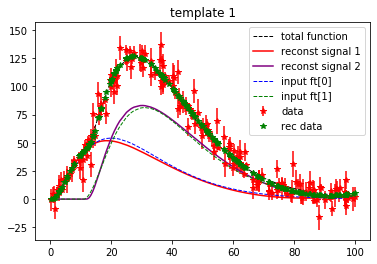

Chi^2 actual= 201.93980717339548 Chi^2 pystan rec= 193.6785419540103


In [202]:
#template 1: log-normal, crossing statistics upto 4th order

tmax=np.amax(t)

def mod(x,mean,sig,s,c0,c1,c2,c3,c4):
    x=x-s*x;#s=stretch
    x[x<1e-15]=1e-15# this makes the intrinsic flux->0 for t<0
    #log-normal
    fx=(1.0/(sig*np.sqrt(2.0*np.pi)*x))*np.exp(-0.5*(np.log(x)-mean)**2/(sig*sig))
    #crossing statistics
    xs=x/tmax
    fx_mod=fx*(c0+c1*xs+c2*(2.0*xs*xs -1.0)+c3*(4.0*xs*xs*xs-3.0*xs) + c4*(8.0*xs*xs*xs*xs-8.0*xs*xs + 1.0));
    return fx_mod

#with lmfit emcee (MCMC)
p = lmfit.Parameters()
p.add_many(('mean', 1.0, True, 0.1,5.0), ('sig', 0.5, True, 0.0,2.0),('s', 0.01,True, 0.0,0.99));#, ;
p.add_many(('mu1', 1.5, True, 0.5,2.0),('dt1',-10.0, True,-20.0,0.0));
#p.add('dt2', value=0.50, min=0, max=10.0)
p.add_many(('c0', 600.0, True,10.0,1500.0),('c1', 0.1, True, None,None),('c2', 0.1, True, None,None),
           ('c3', 0.1, True, None,None) ,('c4', 0.1, True, None,None))

def residual(p):
    v = p.valuesdict()
    return (mod(t,v['mean'],v['sig'],v['s'],v['c0'],v['c1'],v['c2'],v['c3'],v['c4'])+v['mu1']*mod(t+v['dt1'],v['mean'],v['sig'],v['s'],v['c0'],v['c1'],v['c2'],v['c3'],v['c4'])- y)/sigft


p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

res7 = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=400, steps=6000, thin=3, nwalkers=150,
                     params=p, is_weighted=False)
lmfit.report_fit(res7.params)
plot_func1(res7)

100%|██████████| 6000/6000 [03:01<00:00, 32.99it/s]


[[Variables]]
    n:          1.71955649 +/- 0.20382613 (11.85%) (init = 2)
    tk:         11.0170068 +/- 1.20905782 (10.97%) (init = 10)
    s:          0 (fixed)
    mu1:        1.58659014 +/- 0.15141274 (9.54%) (init = 1.5)
    dt1:       -11.2564855 +/- 0.41514611 (3.69%) (init = -10)
    c0:         0.64953614 +/- 1.24721750 (192.02%) (init = 1)
    c1:         0.87995171 +/- 3.02560560 (343.84%) (init = 0.1)
    c2:        -0.85179207 +/- 1.56132764 (183.30%) (init = 0.1)
    c3:         0 (fixed)
    c4:         0 (fixed)
    __lnsigma:  0.00767451 +/- 0.05366912 (699.32%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(c0, c2)         =  0.969
    C(c0, c1)         = -0.925
    C(c1, c2)         = -0.908
    C(n, mu1)         = -0.729
    C(n, c2)          =  0.722
    C(n, tk)          = -0.654
    C(n, c1)          = -0.549
    C(n, c0)          =  0.545
    C(tk, mu1)        =  0.527
    C(n, dt1)         =  0.500
    C(mu1, dt1)       = -0.3

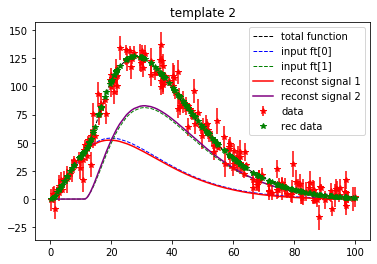

Chi^2 actual= 201.93980717339548 Chi^2 pystan rec= 193.4453992879466


In [203]:
#template 2: t^n exp(-t/tk); no stretch, crossing statistics upto 2nd order

tmax=np.amax(t)

def mod2(x,n,xk,s,c0,c1,c2,c3,c4):
    x=x-s*x;
    x[x<1e-15]=1e-15
    fx=(x**n)*np.exp(-x/xk)
    xs=x/tmax
    fx_mod=fx*(c0+c1*xs+c2*(2.0*xs*xs-1)+c3*(4.0*xs*xs*xs-3.0*xs) + c4*(8.0*xs*xs*xs*xs-8.0*xs*xs+1.0));
    return fx_mod

#with lmfit emcee (MCMC)
p = lmfit.Parameters()
p.add_many(('n', 2.0, True, 1.0,4.0), ('tk', 10.0, True, 5.0,20.0),('s', 0,False, 0.0,0.5));#, ;
p.add_many(('mu1', 1.5, True, 0.5,2.0),('dt1',-10.0, True,-20.0,0.0));
#p.add('dt2', value=0.50, min=0, max=10.0)
p.add_many(('c0', 1.0, True,None,None),('c1', 0.1, True, None,None),('c2', 0.1, True, None,None),
           ('c3', 0, False, None,None) ,('c4', 0.0,False, None,None))

def residual(p):
    v = p.valuesdict()
    return (mod2(t,v['n'],v['tk'],v['s'],v['c0'],v['c1'],v['c2'],v['c3'],v['c4'])
            +v['mu1']*mod2(t+v['dt1'],v['n'],v['tk'],v['s'],v['c0'],v['c1'],v['c2'],v['c3'],v['c4'])- y)/sigft


p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

res8 = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=400, steps=6000, thin=3, nwalkers=150,
                     params=p, is_weighted=False,seed=20145)
lmfit.report_fit(res8.params)
plot_func2(res8)

In conclusion, we found that crossing statistics together with both the templates is doing well to reconstruct the images, each have its own advantages. 

It is easier to resolve the system where one image arives so late that it has a flat zero plateau.

We have to see how this fitting method works when we have fewer data points but multiple bands. 

The mock data here were generated by the function $t^2 \exp(-t/10)$, so we expect that template 2 should work better even if we had not considered any crossing statistics. We have to test if template 2 works reasonably well if the data are generated using a different function. 